# LiRa Shadow Models 160M

@Jeffrey the only changes I made was memoized roc plotting (so you don't have to run inference per threshold) and saving/loading models in sequence to fit the larger models reasonably. I'm not sure why there is such a difference in your 70M model, although Marvin has said before that the 70M one was just very sus and outlier-like in general, so maybe that's it?

In [34]:
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from datasets import load_dataset
from transformers import GPTNeoXForCausalLM, AutoTokenizer
from transformers.optimization import AdamW
from transformers import Trainer, TrainingArguments
import pickle
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

device = "cuda" if torch.cuda.is_available() else "cpu"

## Memory statistics. I had to be careful with cuda memory 
def mem_stats():
    t = torch.cuda.get_device_properties(0).total_memory / 1024**3
    r = torch.cuda.memory_reserved(0) / 1024**3
    a = torch.cuda.memory_allocated(0) / 1024**3
    print(f"Total Memory: {t:.2f} GB\n"
          f"Reserved Memory: {r:.2f} GB ({(100*(r/t)):.2f}%)\n"
          f"Remaining Memory: {t-r:.2f} GB ({(100*(t-r)/t):.2f}%)\n"
          f"---------------------------------\n"
          f"Allocated Memory: {a:.2f} GB ({(100*(a/t)):.2f}%)\n"
          f"Percent of Reserved Allocated: {(100*(a+1e-9)/(r+1e-9)):.2f}%\n")

In [2]:
from datasets import load_dataset

dataset = load_dataset("amazon_us_reviews", "Baby_v1_00") # Baby reviews a bit more distinctive than CPU

Found cached dataset amazon_us_reviews (/home/ec2-user/.cache/huggingface/datasets/amazon_us_reviews/Baby_v1_00/0.1.0/17b2481be59723469538adeb8fd0a68b0ba363bbbdd71090e72c325ee6c7e563)


  0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
# Settings
small_string_filter = 20 # filters small strings 
dataset_division_constant = 250
early_stop_patience = 1 # >= 1 (if val loss increases, runs early_stop_patience more epochs, then stops)

# Parameters
N = 12 # num_models (more doesn't necessarily help that much; I tried 16)
epochs = 12 # epochs to train (unless validation loss rises)
bs = 1
learn = 5e-5
mod_size = "160m"

In [4]:
# Deduping and getting rid of extremely short strings 
global_dataset = dataset["train"]['review_body'][:len(dataset["train"])//dataset_division_constant]
print(f"Dataset Len: {len(global_dataset)}")
global_dataset = list(set(entry for entry in global_dataset))
print(f"Dataset Len: {len(global_dataset)}")
global_dataset = list(set(entry for entry in global_dataset if len(entry) > small_string_filter))
print(f"Dataset Len: {len(global_dataset)}")

Dataset Len: 7011
Dataset Len: 6694
Dataset Len: 6130


In [5]:
validation = dataset["train"]['review_body'][len(dataset["train"])//dataset_division_constant: 2*len(dataset["train"])//dataset_division_constant]
validation = list(set(entry for entry in validation if len(entry) > small_string_filter))

In [6]:
validation = validation[:len(validation) // 2]
print(len(validation))

3112


# Data Creation

In [7]:
# Train until train loss = val loss
tokenizer = AutoTokenizer.from_pretrained(f"EleutherAI/pythia-{mod_size}-deduped")

In [8]:
def collate_fn(batch):
    global model
    tokens = [tokenizer.encode(example, return_tensors="pt", truncation=True,max_length=model.config.max_position_embeddings) for example in batch]
    max_length = max([t.size(1) for t in tokens])
    tokens_padded = [torch.cat([t, t.new_zeros(t.size(0), max_length - t.size(1))], dim=1) for t in tokens]
    tokens_padded = torch.cat(tokens_padded, dim=0)
    return {
        "input_ids":tokens_padded,
        "labels":tokens_padded,
        "attention_mask": (tokens_padded > 0).clone().detach().to(dtype=torch.int)
    }

In [9]:
def arr_split(chunks, N):
    if N % 2 != 0:
        print("Need even N!")
        return []
    lists = [[] for i in range(N)]

    for i in range(N):
        for j in range(i, int(i + N/2)):
            lists[i] += chunks[j % N]

    return lists

In [10]:
def orthogonal_chunk(i):
    return int(N/2 + i) % N

In [11]:
data_chunks = [global_dataset[i * len(global_dataset)//N : (i+1) * len(global_dataset) // N] for i in range(N)]

In [12]:
data_arr = arr_split(data_chunks, N)

In [13]:
len(data_arr[0])

3065

# Fine Tune Method

In [14]:
def train(model, train_dataset, val_dataset, collate_fn, batch_size, epochs):
    model = model.to(device)
    model.config.use_cache = False
    training_args = TrainingArguments(output_dir="fine-tuning",
                                    do_train=True,
                                    do_eval=True,
                                    num_train_epochs=epochs,
                                    per_device_train_batch_size=batch_size,
                                    per_device_eval_batch_size=batch_size,
                                    evaluation_strategy="epoch",
                                    logging_strategy="epoch",
                                    save_strategy="epoch",
                                    gradient_accumulation_steps=1,
                                    gradient_checkpointing=False,
                                    load_best_model_at_end = True,
                                    optim="adafactor",
                                    )
    trainer = Trainer(model=model,
                    args=training_args,
                    train_dataset=train_dataset,
                    eval_dataset=val_dataset,
                    tokenizer=tokenizer,
                    data_collator=collate_fn,
                    callbacks=[EarlyStoppingCallback(early_stop_patience, 0.0)] # if val loss improve for >1 iterations, end. 
                  )
    trainer.train()
    return model

# Base Model (to be attacked)

In [15]:
# Fine tune a model on the first 6 chunks of data

from transformers import EarlyStoppingCallback
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
model = GPTNeoXForCausalLM.from_pretrained(f"EleutherAI/pythia-{mod_size}-deduped").to(device)
train(model, data_arr[0], data_arr[orthogonal_chunk(0)], collate_fn, bs, epochs)
model.save_pretrained("lira_large/pythia-160m", from_pt=True) 
del model
torch.cuda.empty_cache()

cuda


# Shadow Models

In [16]:
for i in range(N):
    print(f"Model #{i}")
    model = GPTNeoXForCausalLM.from_pretrained(f"EleutherAI/pythia-{mod_size}-deduped").to(device)
    mem_stats()
    model = train(model, data_arr[i], data_arr[orthogonal_chunk(i)], collate_fn, bs, epochs)
    model.save_pretrained(f"lira_large/pythia-160m-shadow-{i}", from_pt=True) 
    del model
    torch.cuda.empty_cache()
    mem_stats()

# Evaluation

In [17]:
def get_in_models(chunk_no, N):
    """
    Returns a list of models that should be used for inference for a given chunk
    """
    ins = []
    outs = []
    for i in range(N):
        lower = i
        upper = int(i+N/2)
        innit = False
        for j in range(lower, upper):
            if chunk_no == j % N:
                innit = True
        if innit:
            ins.append(i)
        else:
            outs.append(i)
    return (ins, outs)

In [18]:
from torch.nn import CrossEntropyLoss
import math

def compute_ce_loss(model, tokenizer, string):
    input_ids = tokenizer.encode(string, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model(input_ids)
        logits = outputs.logits

    loss_fn = CrossEntropyLoss()
    input_len = input_ids.shape[-1] - 1
    input_ids_without_first_token = input_ids[:, 1:]
    logits_without_last_token = logits[:, :-1, :]
    loss = loss_fn(logits_without_last_token.view(-1, logits.size(-1)), input_ids_without_first_token.view(-1))
    return loss

def compute_confidence(ce_loss):
    conf = math.exp(-1 * ce_loss)
    return math.log(conf / (1-conf))

In [20]:
import random
import scipy.stats as stats

def conf_nums(paths, ins, exs, tokenizer):
    confs = []
    for i, path in enumerate(paths):
        model = GPTNeoXForCausalLM.from_pretrained(path).to(device)
        if i in ins:
            for ex in exs:
                ce_loss = compute_ce_loss(model, tokenizer, ex)
                confs.append(compute_confidence(ce_loss))
        del model
        torch.cuda.empty_cache()
    return (np.mean(confs), np.std(confs))

In [21]:
# We're considering a "chunk" as a discrete entity

results = []
for i, chunk in enumerate(data_chunks):
    print(f"Processing Chunk {i}...")
    ins, outs = get_in_models(i, N)
    # Get Random Samples
    exs = random.sample(chunk, 25)

    # Get IN Mu/Stdev
    mu_in, std_in = conf_nums([f"./lira_large/pythia-160m-shadow-{i}" for i in range(N)], ins, exs, tokenizer)

    # Get OUT Mu/Stdev
    mu_out, std_out = conf_nums([f"./lira_large/pythia-160m-shadow-{i}" for i in range(N)], outs, exs, tokenizer)

    # Get TARGET Mu
    mu_target, std_target = conf_nums([f"./lira_large/pythia-160m"], [0], exs, tokenizer)

    likelihood_in = stats.norm.pdf(mu_target, mu_in, std_in)
    likelihood_out = stats.norm.pdf(mu_target, mu_out, std_out)
    lira = likelihood_in / likelihood_out
    in_true_model = i >= 0 and i < N/2
    results.append((likelihood_in,likelihood_out,lira,in_true_model))
    print(f"Likelihood In: {likelihood_in}\n"
          f"Likelihood Out: {likelihood_out}\n"
          f"LiRa: {lira}\n"
          f"In True Mode: {in_true_model}\n")
    
with open("./lira_large/lira.pickle","wb") as f:
    pickle.dump(results,f)

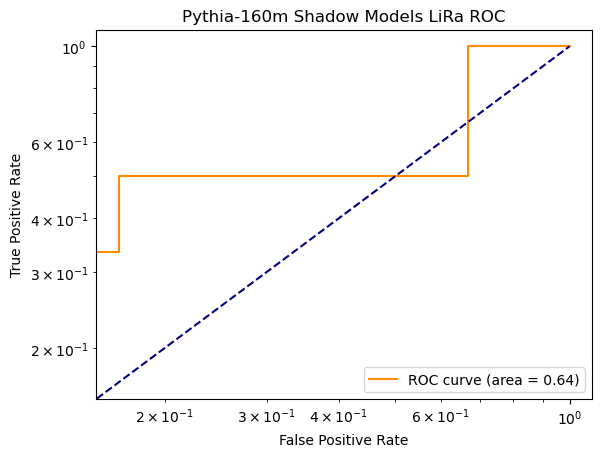

In [81]:
with open("./lira_large/lira.pickle","rb") as f:
    results = pickle.load(f)
# Generate ROC curve 
fpr, tpr, thresholds = roc_curve([int(result[3]) for result in results], [result[2] for result in results])
roc_auc = auc(fpr, tpr)
plt.figure()
plt.loglog(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title(f"Pythia-{mod_size} Shadow Models LiRa ROC")
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()